In [4]:
import requests
import json
from bs4 import BeautifulSoup
from lxml import etree
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import synonyms
import jieba

[jieba] default dict file path ../data/vocab.txt
>> Synonyms load wordseg dict [/opt/anaconda3/lib/python3.8/site-packages/synonyms/data/vocab.txt] ... 
>> Synonyms on loading stopwords [/opt/anaconda3/lib/python3.8/site-packages/synonyms/data/stopwords.txt] ...
[Synonyms] on loading vectors [/opt/anaconda3/lib/python3.8/site-packages/synonyms/data/words.vector.gz] ...


In [5]:
fund_list = {'001718': ('张宇帆', '工银物流产业股票'), '288001': ('佟巍', '华夏经典混合'), '530011': ('孙晟', '建信内生动力混合'),
            '001532': ('刘畅畅', '华安文体健康混合A'), '519704': ('刘鹏', '交银先进制造混合'), '519185': ('黄海', '万家精选混合'),
            '005228': ('陈健玮', '汇添富港股通专注成长'), '005583': ('杨添琦', '易方达港股通红利混合'), 
            '008861': ('陶星言', '西部利得港股通新机遇混合A'), '010326': ('王诗瑶', '博时消费创新混合A')
            }

In [6]:
def chicang_info(season, fund_code):
    url = 'http://fundf10.eastmoney.com/FundArchivesDatas.aspx?type=jjcc&code=' + fund_code + '&topline=10&year=' + season + '&month=&rt=0.521395962770737'
    df = pd.DataFrame(columns=['持仓排名', '股票代码', '股票名称', '占净值比例', '持股数（万股）', '持仓市值（万元）', '季度'])
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,"html.parser")
    results_page
    table_list = results_page.find_all('table',{'class': 'w782 comm tzxq'})
    if len(table_list)==0:
        table_list = results_page.find_all('table',{'class': 'w782 comm tzxq t2'})
    flag = True
    for i in range(len(table_list)):
        season_cnt = re.search(r'(202[\d+])年([\d+])季度股票投资明细',results_page.find_all('h4')[i].get_text())[2]
        tr_list = table_list[i].find('tbody').find_all('tr')
        if flag and season == '2021':
            for tr in tr_list:
                td_list = tr.find_all('td')
                df = df.append({'持仓排名': td_list[0].get_text(), '股票代码': td_list[1].get_text(), '股票名称': td_list[2].get_text(), '占净值比例': td_list[6].get_text(), '持股数（万股）': td_list[7].get_text(), '持仓市值（万元）': td_list[8].get_text(), '季度':season+'-'+season_cnt}, ignore_index=True)

            flag = False
        else:
            for tr in tr_list:
                td_list = tr.find_all('td')
                df = df.append({'持仓排名': td_list[0].get_text(), '股票代码': td_list[1].get_text(), '股票名称': td_list[2].get_text(), '占净值比例': td_list[4].get_text(), '持股数（万股）': td_list[5].get_text(), '持仓市值（万元）': td_list[6].get_text(), '季度':season+'-'+season_cnt}, ignore_index=True)





    df['基金代码'] = fund_code
    df['基金经理'] = fund_list[fund_code][0]
    df['基金名称'] = fund_list[fund_code][1]
    return df

In [7]:
#爬取2021及2020年的持仓信息
chicang = pd.DataFrame(columns=['股票代码', '股票名称', '占净值比例', '持股数（万股）', '持仓市值（万元）'])
for fund_code in fund_list.keys():
    chicang = chicang.append(chicang_info('2021', fund_code))
    chicang = chicang.append(chicang_info('2020', fund_code))
#cleaning data
chicang = chicang.reset_index()
chicang.drop(['index'], axis = 1, inplace=True)
chicang['占净值比例'] = chicang['占净值比例'].map(lambda x: x.replace('%', '')).astype('float64')
chicang = chicang.astype({'持仓排名': 'int32'})
chicang = chicang[(chicang['季度'] == '2021-3')|(chicang['季度'] == '2021-2')|(chicang['季度'] == '2021-1')|(chicang['季度'] == '2020-4')|(chicang['季度'] == '2020-3')]
chicang

,股票代码,股票名称,占净值比例,持股数（万股）,持仓市值（万元）,持仓排名,季度,基金代码,基金经理,基金名称
0,002120,韵达股份,6.72,539.42,"10,383.76",1,2021-3,001718,张宇帆,工银物流产业股票
1,300750,宁德时代,5.47,16.06,"8,443.22",2,2021-3,001718,张宇帆,工银物流产业股票
2,300627,华测导航,4.70,171.20,"7,267.44",3,2021-3,001718,张宇帆,工银物流产业股票
3,002352,顺丰控股,3.50,82.80,"5,411.10",4,2021-3,001718,张宇帆,工银物流产业股票
4,600563,法拉电子,2.96,25.61,"4,578.04",5,2021-3,001718,张宇帆,工银物流产业股票
...,...,...,...,...,...,...,...,...,...,...
645,00700,腾讯控股,3.69,56.60,"26,867.17",6,2020-4,010326,王诗瑶,博时消费创新混合A
646,002311,海大集团,3.61,402.31,"26,351.39",7,2020-4,010326,王诗瑶,博时消费创新混合A
647,600690,海尔智家,3.21,800.94,"23,395.38",8,2020-4,010326,王诗瑶,博时消费创新混合A
648,01810,小米集团-W,2.82,735.24,"20,544.41",9,2020-4,010326,王诗瑶,博时消费创新混合A


In [8]:
stock_dict = {}
for stock_code in list(chicang['股票代码'].unique()):
    try:
        url = 'http://quote.eastmoney.com/sh' + stock_code + '.html'
        response = requests.get(url)
#         if response.status_code == 200:
#             print("Success")
#         else:
#             print("Failure")
        results_page = BeautifulSoup(response.content,"html.parser")
        results_page.find('div',{'class': 'mt9 title1'})
        stock_industry = re.search(r'\[(.*)\]',results_page.find('div',{'class': 'mt9 title1'}).find('h3').get_text())[1]
        stock_dict[stock_code] = stock_industry
    except:
        try:
            url = 'http://quote.eastmoney.com/sz' + stock_code + '.html'
            response = requests.get(url)
    #         if response.status_code == 200:
    #             print("Success")
    #         else:
    #             print("Failure")
            results_page = BeautifulSoup(response.content,"html.parser")
            results_page.find('div',{'class': 'mt9 title1'})
            stock_industry = re.search(r'\[(.*)\]',results_page.find('div',{'class': 'mt9 title1'}).find('h3').get_text())[1]
            stock_dict[stock_code] = stock_industry
        except:
            continue
industry_set = set(stock_dict.values())



{'002120': '交运物流',
 '300750': '电池',
 '300627': '电子信息',
 '002352': '交运物流',
 '600563': '电子元件',
 '002812': '电池',
 '603129': '交运设备',
 '603290': '半导体',
 '600660': '玻璃玻纤',
 '002179': '电子元件',
 '601021': '民航机场',
 '603659': '电池',
 '603960': '专用设备',
 '002594': '汽车整车',
 '600399': '钢铁行业',
 '300747': '电子元件',
 '600377': '高速公路',
 '600900': '电力行业',
 '601939': '银行',
 '601006': '交运物流',
 '601288': '银行',
 '601668': '工程建设',
 '600548': '高速公路',
 '600018': '港口水运',
 '002415': '安防设备',
 '601633': '汽车整车',
 '601899': '贵金属',
 '603678': '电子元件',
 '601318': '保险',
 '002833': '专用设备',
 '300777': '化纤行业',
 '603236': '电子元件',
 '603444': '软件服务',
 '603337': '专用设备',
 '000913': '交运设备',
 '300251': '文化传媒',
 '002430': '专用设备',
 '002539': '化肥行业',
 '000902': '化肥行业',
 '002241': '消费电子',
 '000893': '化肥行业',
 '300724': '专用设备',
 '600011': '电力行业',
 '600988': '贵金属',
 '000848': '食品饮料',
 '600519': '酿酒行业',
 '002145': '化学原料',
 '000933': '有色金属',
 '601601': '保险',
 '600352': '化学制品',
 '600486': '农药兽药',
 '603712': '通讯行业',
 '601919': '港口水运',
 '000547':

In [9]:
# chicang['行业'] = chicang['股票代码'].map(lambda x: stock_dict[x] if x in stock_dict.keys() else '')
# chicang

,股票代码,股票名称,占净值比例,持股数（万股）,持仓市值（万元）,持仓排名,季度,基金代码,基金经理,基金名称,行业
0,002120,韵达股份,6.72,539.42,"10,383.76",1,2021-3,001718,张宇帆,工银物流产业股票,交运物流
1,300750,宁德时代,5.47,16.06,"8,443.22",2,2021-3,001718,张宇帆,工银物流产业股票,电池
2,300627,华测导航,4.70,171.20,"7,267.44",3,2021-3,001718,张宇帆,工银物流产业股票,电子信息
3,002352,顺丰控股,3.50,82.80,"5,411.10",4,2021-3,001718,张宇帆,工银物流产业股票,交运物流
4,600563,法拉电子,2.96,25.61,"4,578.04",5,2021-3,001718,张宇帆,工银物流产业股票,电子元件
...,...,...,...,...,...,...,...,...,...,...,...
645,00700,腾讯控股,3.69,56.60,"26,867.17",6,2020-4,010326,王诗瑶,博时消费创新混合A,
646,002311,海大集团,3.61,402.31,"26,351.39",7,2020-4,010326,王诗瑶,博时消费创新混合A,农牧饲渔
647,600690,海尔智家,3.21,800.94,"23,395.38",8,2020-4,010326,王诗瑶,博时消费创新混合A,家电行业
648,01810,小米集团-W,2.82,735.24,"20,544.41",9,2020-4,010326,王诗瑶,博时消费创新混合A,


In [14]:
def jingzhi_info(fund_code):
    url = 'http://api.fund.eastmoney.com/f10/lsjz?fundCode=' + fund_code + '&pageIndex=1&pageSize=365'
    headers = {"Referer": "http://fundf10.eastmoney.com/"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Failure", response.status_code)
    response.encoding='UTF-8' #编码用utf-8
    df = pd.DataFrame(response.json()['Data']['LSJZList'])
    df['基金代码'] = fund_code
    df['基金经理'] = fund_list[fund_code][0]
    df['基金名称'] = fund_list[fund_code][1]
    return df

In [15]:
#爬取过去365个交易日的基金净值
jingzhi = pd.DataFrame(columns=['FSRQ', 'DWJZ', 'LJJZ', 'SDATE', 'ACTUALSYI', 'NAVTYPE', 'JZZZL',
       'SGZT', 'SHZT', 'FHFCZ', 'FHFCBZ', 'DTYPE', 'FHSP'])
for fund_code in fund_list.keys():
    jingzhi = jingzhi.append(jingzhi_info(fund_code))
#cleaning data
jingzhi = jingzhi.reset_index()
jingzhi.drop(['index', 'SDATE', 'ACTUALSYI', 'NAVTYPE', 'FHFCZ', 'FHFCBZ', 'DTYPE', 'FHSP'], axis = 1, inplace=True)
jingzhi.rename(columns={'FSRQ': '净值日期', 'DWJZ':'单位净值', 'LJJZ':'累计净值', 'JZZZL':'日增长率',
       'SGZT':'申购状态', 'SHZT':'赎回状态'}, inplace=True)
jingzhi.replace('', np.nan, inplace = True)
jingzhi = jingzhi.astype({'单位净值': 'float64', '累计净值': 'float64', '日增长率': 'float64'})
jingzhi

,净值日期,单位净值,累计净值,日增长率,申购状态,赎回状态,基金代码,基金经理,基金名称
0,2021-11-26,4.0410,4.0410,-0.44,开放申购,开放赎回,001718,张宇帆,工银物流产业股票
1,2021-11-25,4.0590,4.0590,-0.71,开放申购,开放赎回,001718,张宇帆,工银物流产业股票
2,2021-11-24,4.0880,4.0880,-0.58,开放申购,开放赎回,001718,张宇帆,工银物流产业股票
3,2021-11-23,4.1120,4.1120,-0.15,开放申购,开放赎回,001718,张宇帆,工银物流产业股票
4,2021-11-22,4.1180,4.1180,2.13,开放申购,开放赎回,001718,张宇帆,工银物流产业股票
...,...,...,...,...,...,...,...,...,...
3450,2020-11-20,1.0103,1.0103,NaN,封闭期,封闭期,010326,王诗瑶,博时消费创新混合A
3451,2020-11-13,1.0074,1.0074,NaN,封闭期,封闭期,010326,王诗瑶,博时消费创新混合A
3452,2020-11-06,1.0086,1.0086,NaN,封闭期,封闭期,010326,王诗瑶,博时消费创新混合A
3453,2020-10-30,0.9981,0.9981,NaN,封闭期,封闭期,010326,王诗瑶,博时消费创新混合A


In [16]:
def get_description(fund_code, season, doc_code):
#     print(fund_code, season)
    url = 'https://np-cnotice-fund.eastmoney.com/api/content/ann?client_source=web_fund&show_all=1&art_code='+doc_code
    headers = {"Referer": "http://fundf10.eastmoney.com/"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Failure", response.status_code)
    response.encoding='UTF-8' #编码用utf-8
    report_text = response.json()['data']['notice_content']
    try:
        description = re.search(r'投资策略和运作分析([\s\S]*?)4.5', report_text)[1]
        description = description.replace('\n','')
        description = description.replace('\r','')
        description = description.replace(' ','')
        return (description,season,fund_code,fund_list[fund_code][0],fund_list[fund_code][1])
    except:
        print(fund_code, season)
        return None
    
    
    

In [17]:
def get_report_link(fund_code):
    url = 'http://api.fund.eastmoney.com/f10/JJGG?&fundcode=' + fund_code + '&pageIndex=1&pageSize=20&type=3'
    headers = {"Referer": "http://fundf10.eastmoney.com/"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Failure", response.status_code)
    response.encoding='UTF-8' #编码用utf-8
    df = pd.DataFrame(response.json()['Data'])
    season_tick = ['2021-3', '2021-mid', '2021-2', '2021-1', '2020-abstract', '2020-year', '2020-4', '2020-3']
    return dict(zip(season_tick,list(df['ID'])))


In [18]:
#从研报中爬取投资策略与运作分析板块
analysis_list = list()
for fund_code in fund_list.keys():
    doc_dict = get_report_link(fund_code)
    for season, doc_code in doc_dict.items():
        if season in ('2021-mid', '2020-abstract', '2020-year'):
            continue
        analysis = get_description(fund_code, season, doc_code)
        if analysis is not None:
            analysis_list.append(get_description(fund_code, season, doc_code))
analysis_df = pd.DataFrame(analysis_list, columns=['投资策略与运作分析', '季度', '基金代码', '基金经理', '基金名称'])

008861 2020-3


In [19]:
analysis_df

,投资策略与运作分析,季度,基金代码,基金经理,基金名称
0,2021年三季度，全球来看，疫苗注射继续推进，国内全程接种率达到70%以上。美联储缩减购债规...,2021-3,001718,张宇帆,工银物流产业股票
1,2021年二季度，全球来看，疫苗注射继续稳步推进，虽然其中还不断出现疫情的反复，但是整体疫情...,2021-2,001718,张宇帆,工银物流产业股票
2,2021年一季度，全球来看，疫苗注射的推进速度加快，虽然还不断出现疫情的反复，但是整体疫情的...,2021-1,001718,张宇帆,工银物流产业股票
3,2020年四季度，全球经济延续复苏态势。海外疫情有所反复，但全球疫苗研发取得突破性进展，疫情...,2020-4,001718,张宇帆,工银物流产业股票
4,2020年三季度，全球经济延续复苏态势，但节奏有所放缓。海外疫情有所反复，欧美疫情出现二次爆...,2020-3,001718,张宇帆,工银物流产业股票
5,回顾三季度，国内经济继续降温。地产销售明显下滑，8月份地产销售同比下滑20%，9月份地产销售...,2021-3,288001,佟巍,华夏经典混合
6,回顾二季度，国内经济开始逐渐降温。4月份和5月份规模以上工业增加值两年平均增长分别为6.8%...,2021-2,288001,佟巍,华夏经典混合
7,回顾一季度，国内经济延续了去年四季度的强势，即使考虑去年疫情对于基数的影响，经济运行依然强劲...,2021-1,288001,佟巍,华夏经典混合
8,回顾四季度，随着国内疫情的持续缓解，同时以美国为代表的海外需求的快速恢复，国内经济活动延续三...,2020-4,288001,佟巍,华夏经典混合
9,回顾三季度，随着疫情的持续缓解，国内经济活动延续二季度的反弹趋势。国内经济增长方面，生产数据...,2020-3,288001,佟巍,华夏经典混合


In [21]:
def zzpz_info(fund_code):
    url = 'http://fundf10.eastmoney.com/zcpz_' + fund_code + '.html'
    table_list = pd.read_html(url, encoding = 'UTF-8')
    table_list[1]['基金代码'] = fund_code
    table_list[1]['基金经理'] = fund_list[fund_code][0]
    table_list[1]['基金名称'] = fund_list[fund_code][1]
    table_list[1]['报告期'] = table_list[1]['报告期'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return table_list[1]



In [22]:
#资产配置信息（股票/债券/现金比例）
zzpz = pd.DataFrame(columns=['报告期', '股票占净比', '债券占净比', '现金占净比', '净资产（亿元）'])
for fund_code in fund_list.keys():
    zzpz = zzpz.append(zzpz_info(fund_code))
zzpz = zzpz.reset_index()
zzpz.drop(['index'], axis = 1, inplace=True)
zzpz.replace('---', '0%', inplace = True)
zzpz['股票占净比'] = zzpz['股票占净比'].map(lambda x: x.replace('%', '')).astype('float64')
zzpz['债券占净比'] = zzpz['债券占净比'].map(lambda x: x.replace('%', '')).astype('float64')
zzpz['现金占净比'] = zzpz['现金占净比'].map(lambda x: x.replace('%', '')).astype('float64')
zzpz=zzpz.assign(上期净资产= lambda x: x['净资产（亿元）'].shift(-1))
zzpz

,报告期,股票占净比,债券占净比,现金占净比,净资产（亿元）,基金代码,基金经理,基金名称
0,2021-09-30,86.58,0.00,12.47,15.45,001718,张宇帆,工银物流产业股票
1,2021-06-30,89.79,0.00,10.63,5.11,001718,张宇帆,工银物流产业股票
2,2021-03-31,81.30,0.00,21.99,2.05,001718,张宇帆,工银物流产业股票
3,2020-12-31,89.67,0.00,10.99,1.74,001718,张宇帆,工银物流产业股票
4,2020-09-30,92.20,0.09,5.67,1.18,001718,张宇帆,工银物流产业股票
...,...,...,...,...,...,...,...,...
275,2020-09-30,86.87,0.00,13.45,0.54,008861,陶星言,西部利得港股通新机遇混合A
276,2021-09-30,89.84,0.00,10.69,24.65,010326,王诗瑶,博时消费创新混合A
277,2021-06-30,89.35,3.30,7.19,33.41,010326,王诗瑶,博时消费创新混合A
278,2021-03-31,87.98,2.94,10.36,37.48,010326,王诗瑶,博时消费创新混合A


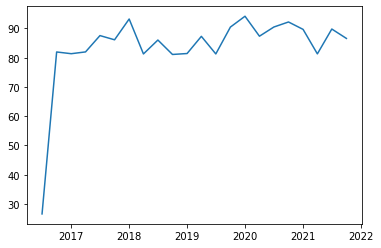

In [23]:
zzpz_trend = zzpz[zzpz['基金代码']=='001718'].iloc[:,:2]
plt.plot(zzpz_trend['报告期'], zzpz_trend['股票占净比'])
plt.show()

In [24]:
def hypz_info(season, fund_code):
    url = 'http://api.fund.eastmoney.com/f10/HYPZ/?fundCode=' + fund_code + '&year=' + season
    headers = {"Referer": "http://fundf10.eastmoney.com/"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Failure", response.status_code)
    response.encoding='UTF-8' #编码用utf-8
    l = response.json()['Data']['QuarterInfos']
    totaldf = pd.DataFrame()
    for element in l:
        df = pd.DataFrame(element['HYPZInfo'])
        totaldf = totaldf.append(df)
    totaldf.reset_index(inplace=True)
    totaldf['index'] = totaldf['index'].map(lambda x:x+1)
    return totaldf

In [207]:
hypz[hypz['基金代码'] == '001718']

,权重排名,基金代码,季度,行业代码,行业名称,市值（万元）,占净值比例,上期占净值比例,占净值比例变动,基金名称
0,1,001718,2021-09-30,C,制造业,95732.88,61.97,68.89,-6.92,工银物流产业股票
1,2,001718,2021-09-30,G,交通运输、仓储和邮政业,21176.14,13.71,13.39,0.32,工银物流产业股票
2,3,001718,2021-09-30,I,信息传输、软件和信息技术服务业,5874.59,3.80,1.35,2.45,工银物流产业股票
3,4,001718,2021-09-30,J,金融业,5608.75,3.63,1.82,1.81,工银物流产业股票
4,5,001718,2021-09-30,L,租赁和商务服务业,1771.06,1.15,0.87,0.28,工银物流产业股票
...,...,...,...,...,...,...,...,...,...,...
31,3,001718,2020-03-31,R,文化、体育和娱乐业,499.49,6.04,NaN,NaN,工银物流产业股票
32,4,001718,2020-03-31,F,批发和零售业,451.76,5.46,NaN,NaN,工银物流产业股票
33,5,001718,2020-03-31,N,水利、环境和公共设施管理业,228.97,2.77,NaN,NaN,工银物流产业股票
34,6,001718,2020-03-31,G,交通运输、仓储和邮政业,76.90,0.93,NaN,NaN,工银物流产业股票


In [25]:
#行业配置信息
hypz = pd.DataFrame()
for fund_code in fund_list.keys():
    hypz = hypz.append(hypz_info('2021', fund_code))
    hypz = hypz.append(hypz_info('2020', fund_code))
#cleaning data
hypz.drop(['SZ', 'ZJZBLDesc', 'ABBNAME', 'JJGSID',
       'FTYPE', 'FUNDTYP', 'FEATURE'], axis = 1, inplace = True)
hypz.rename(columns={'index': '权重排名', 'BZDM': '基金代码', 'FSRQ': '季度', 'HYDM': '行业代码', 'HYMC': '行业名称', 'SZDesc': '市值（万元）', 'ZJZBL': '占净值比例', 'SAMMVPCTNV': '上期占净值比例', 'PCTCP': '占净值比例变动', 'SHORTNAME': '基金名称'}, inplace = True)
hypz['市值（万元）'] = hypz['市值（万元）'].map(lambda x: x.replace(',',''))
hypz = hypz.astype({'市值（万元）': 'float64', '占净值比例' : 'float64'})
hypz['季度'] = hypz['季度'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
hypz.reset_index(drop=True)
hypz['上期占净值比例'] = hypz.groupby(['基金代码', '行业代码'])['占净值比例'].shift(-1)
hypz['占净值比例变动'] = hypz['占净值比例'] - hypz['上期占净值比例']
hypz

,权重排名,基金代码,季度,行业代码,行业名称,市值（万元）,占净值比例,上期占净值比例,占净值比例变动,基金名称
0,1,001718,2021-09-30,C,制造业,95732.88,61.97,52.19,9.78,工银物流产业股票
1,2,001718,2021-09-30,G,交通运输、仓储和邮政业,21176.14,13.71,2.20,11.51,工银物流产业股票
2,3,001718,2021-09-30,I,信息传输、软件和信息技术服务业,5874.59,3.80,5.54,-1.74,工银物流产业股票
3,4,001718,2021-09-30,J,金融业,5608.75,3.63,16.36,-12.73,工银物流产业股票
4,5,001718,2021-09-30,L,租赁和商务服务业,1771.06,1.15,1.80,-0.65,工银物流产业股票
...,...,...,...,...,...,...,...,...,...,...
25,6,010326,2021-03-31,F,批发和零售业,2.05,0.00,0.79,-0.79,博时消费创新混合A
0,1,010326,2020-12-31,C,制造业,308044.89,42.25,44.98,-2.73,博时消费创新混合A
1,2,010326,2020-12-31,R,文化、体育和娱乐业,19580.76,2.69,0.93,1.76,博时消费创新混合A
2,3,010326,2020-12-31,Q,卫生和社会工作,3680.48,0.50,3.36,-2.86,博时消费创新混合A


In [26]:
hypz['行业名称'].unique()

array(['制造业', '交通运输、仓储和邮政业', '信息传输、软件和信息技术服务业', '金融业', '租赁和商务服务业', '房地产业',
       '电力、热力、燃气及水生产和供应业', '文化、体育和娱乐业', '批发和零售业', '水利、环境和公共设施管理业',
       '住宿和餐饮业', '科学研究和技术服务业', '建筑业', '采矿业', '农、林、牧、渔业', '卫生和社会工作', '综合',
       '教育'], dtype=object)

In [27]:
# from bert_serving.client import BertClient
# bc = BertClient()


In [28]:
# doc_vecs = bc.encode([analysis_df['投资策略与运作分析'].iloc[0]])
# doc_vecs

In [29]:
jieba.setLogLevel(jieba.logging.INFO)
count = jieba.cut(analysis_df['投资策略与运作分析'][0])

In [41]:
word_count = {}
for i in industry_set:
    count = jieba.cut(i)
    for word in count:
        if word != '行业':
            # 不统计字数为一的词
            if len(word) == 1:
                continue
            else:
                word_count[word] = word_count.get(word, 0) + 1
                

In [43]:
industry_list = list(word_count.keys())
for industry in industry_list:
    if '行业' in industry:
        industry_list.remove(industry)
        industry_list.append(industry[:-2])
industry_list

['民航机场',
 '电池',
 '食品饮料',
 '电子信息',
 '消费',
 '电子',
 '电机',
 '房地产',
 '有色金属',
 '玻璃',
 '玻纤',
 '港口水运',
 '交运',
 '物流',
 '专业',
 '服务',
 '电子元件',
 '医疗服务',
 '农药',
 '兽药',
 '综合',
 '石油',
 '高速公路',
 '安防',
 '设备',
 '软件',
 '汽车整车',
 '医药',
 '制造',
 '造纸',
 '印刷',
 '半导体',
 '化纤',
 '汽车',
 '零部',
 '..',
 '农牧',
 '饲渔',
 '光伏设备',
 '机械行业',
 '化学原料',
 '贵金属',
 '化学制品',
 '通讯',
 '能源',
 '金属',
 '保险',
 '旅游',
 '酒店',
 '化肥',
 '电网',
 '专用设备',
 '工程建设',
 '金属制品',
 '银行',
 '非金属',
 '医疗器械',
 '航天航空',
 '文化传媒',
 '装修',
 '建材',
 '家电',
 '煤炭',
 '电力',
 '钢铁',
 '酿酒']

In [45]:
industry_df = pd.DataFrame(columns = ['行业', '衍生词'])
for industry in industry_list:
    synonym_words = synonyms.nearby(industry)[0]
    for i in range(3):
        try:
            if synonym_words[i] in industry_list and i!=0:
                continue
            industry_df = industry_df.append({'行业':industry, '衍生词':synonym_words[i]}, ignore_index=True)
        except:
            continue

In [46]:
industry_df

,行业,衍生词
0,民航机场,民航机场
1,民航机场,民用机场
2,民航机场,航空港
3,电池,电池
4,电池,电池组
...,...,...
161,钢铁,钢铁
162,钢铁,工程机械
163,钢铁,石化
164,酿酒,酿酒


In [52]:
def get_sentiment_score(text):
    score_list = list()
    url = 'https://aip.baidubce.com/rpc/2.0/nlp/v1/entity_level_sentiment?charset=UTF-8&access_token=24.bf6180be5f2ca69ca843c0ba14dfcd73.2592000.1639842697.282335-25189908'
    headers = {'Content-Type': 'application/json'}
    query1 = {"content": text,
        "title": "测试文章",
        "type": 2,
        "repository": "INDUSTRYONE"}
    body = json.dumps(query1, ensure_ascii=False)
    try:
        response = requests.post(url, data=body.encode('utf-8'), headers=headers)
        score_list.extend(response.json()['items'])
    except:
        pass
    #遍历第二个库
    query2 = {"content": text,
        "title": "测试文章",
        "type": 2,
        "repository": "INDUSTRYTWO"}
    body = json.dumps(query2, ensure_ascii=False)
    try:
        response = requests.post(url, data=body.encode('utf-8'), headers=headers)
        score_list.extend(response.json()['items'])
    except:
        pass
    return score_list

In [53]:
def generate_sentiment_score_df(score_list, i):
    df = pd.DataFrame(score_list, columns =['status', 'pval_neg', 'sentiment', 'pval_pos', 'entity'])
    df = df[df['status'] == 0]
    df['基金代码'] = analysis_df['基金代码'].iloc[i]
    df['基金经理'] = analysis_df['基金经理'].iloc[i]
    df['基金名称'] = analysis_df['基金名称'].iloc[i]
    df['季度'] = analysis_df['季度'].iloc[i]
    return df

In [54]:
sentiment_df = pd.DataFrame()
for i in range(len(analysis_df)):
    score_list = get_sentiment_score(analysis_df['投资策略与运作分析'].iloc[i])
    df = generate_sentiment_score_df(score_list, i)
    sentiment_df = pd.concat([sentiment_df,df])
sentiment_df
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


,status,pval_neg,sentiment,pval_pos,entity,基金代码,基金经理,基金名称,季度
30,0,0.469560,2,0.530440,大宗商品,001718,张宇帆,工银物流产业股票,2021-3
135,0,0.761267,0,0.238733,地产,001718,张宇帆,工银物流产业股票,2021-3
46,0,0.002824,2,0.997176,汽车,001718,张宇帆,工银物流产业股票,2021-2
79,0,0.002564,2,0.997436,能源,001718,张宇帆,工银物流产业股票,2021-2
30,0,0.341471,2,0.658529,大宗商品,001718,张宇帆,工银物流产业股票,2021-1
...,...,...,...,...,...,...,...,...,...
71,0,0.000276,2,0.999724,医疗,010326,王诗瑶,博时消费创新混合A,2020-4
79,0,0.006202,2,0.993798,能源,010326,王诗瑶,博时消费创新混合A,2020-4
97,0,0.008145,2,0.991855,发电,010326,王诗瑶,博时消费创新混合A,2020-4
99,0,0.029284,2,0.970716,家电,010326,王诗瑶,博时消费创新混合A,2020-4


In [61]:
merge_df = sentiment_df.merge(industry_df, left_on = 'entity', right_on = '衍生词')
industry_dict = pd.read_excel('dict.xlsx', names = ['二级行业', '一级行业'])
merge_df = merge_df.merge(industry_dict, left_on = '行业', right_on = '二级行业')
merge_df

,status,pval_neg,sentiment,pval_pos,entity,基金代码,基金经理,基金名称,季度,行业,衍生词,二级行业,一级行业
0,0,0.469560,2,0.530440,大宗商品,001718,张宇帆,工银物流产业股票,2021-3,贵金属,大宗商品,贵金属,采矿业
1,0,0.341471,2,0.658529,大宗商品,001718,张宇帆,工银物流产业股票,2021-1,贵金属,大宗商品,贵金属,采矿业
2,0,0.037022,2,0.962978,大宗商品,288001,佟巍,华夏经典混合,2021-1,贵金属,大宗商品,贵金属,采矿业
3,0,0.619936,0,0.380064,大宗商品,530011,孙晟,建信内生动力混合,2021-1,贵金属,大宗商品,贵金属,采矿业
4,0,0.044148,2,0.955852,大宗商品,008861,陶星言,西部利得港股通新机遇混合A,2021-3,贵金属,大宗商品,贵金属,采矿业
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0.125051,2,0.874949,建材,530011,孙晟,建信内生动力混合,2020-3,建材,建材,建材,建筑业
311,0,0.979276,0,0.020724,建材,010326,王诗瑶,博时消费创新混合A,2021-3,建材,建材,建材,建筑业
312,0,0.049279,2,0.950721,生物医药,008861,陶星言,西部利得港股通新机遇混合A,2020-4,电子信息,生物医药,电子信息,信息传输、软件和信息技术服务业
313,0,0.533645,0,0.466355,物流,010326,王诗瑶,博时消费创新混合A,2021-3,物流,物流,物流,交通运输、仓储和邮政业


In [193]:
merge_df.to_excel('sentiment_df.xlsx')
# pd.read_excel('sentiment_df.xlsx', index_col=0)

,status,pval_neg,sentiment,pval_pos,entity,基金代码,基金经理,基金名称,季度,行业,衍生词,二级行业,一级行业
0,0,0.469560,2,0.530440,大宗商品,1718,张宇帆,工银物流产业股票,2021-3,贵金属,大宗商品,贵金属,采矿业
1,0,0.341471,2,0.658529,大宗商品,1718,张宇帆,工银物流产业股票,2021-1,贵金属,大宗商品,贵金属,采矿业
2,0,0.037022,2,0.962978,大宗商品,288001,佟巍,华夏经典混合,2021-1,贵金属,大宗商品,贵金属,采矿业
3,0,0.619936,0,0.380064,大宗商品,530011,孙晟,建信内生动力混合,2021-1,贵金属,大宗商品,贵金属,采矿业
4,0,0.044148,2,0.955852,大宗商品,8861,陶星言,西部利得港股通新机遇混合A,2021-3,贵金属,大宗商品,贵金属,采矿业
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0.125051,2,0.874949,建材,530011,孙晟,建信内生动力混合,2020-3,建材,建材,建材,建筑业
311,0,0.979276,0,0.020724,建材,10326,王诗瑶,博时消费创新混合A,2021-3,建材,建材,建材,建筑业
312,0,0.049279,2,0.950721,生物医药,8861,陶星言,西部利得港股通新机遇混合A,2020-4,电子信息,生物医药,电子信息,信息传输、软件和信息技术服务业
313,0,0.533645,0,0.466355,物流,10326,王诗瑶,博时消费创新混合A,2021-3,物流,物流,物流,交通运输、仓储和邮政业


In [194]:
merge_df

,status,pval_neg,sentiment,pval_pos,entity,基金代码,基金经理,基金名称,季度,行业,衍生词,二级行业,一级行业
0,0,0.469560,2,0.530440,大宗商品,001718,张宇帆,工银物流产业股票,2021-3,贵金属,大宗商品,贵金属,采矿业
1,0,0.341471,2,0.658529,大宗商品,001718,张宇帆,工银物流产业股票,2021-1,贵金属,大宗商品,贵金属,采矿业
2,0,0.037022,2,0.962978,大宗商品,288001,佟巍,华夏经典混合,2021-1,贵金属,大宗商品,贵金属,采矿业
3,0,0.619936,0,0.380064,大宗商品,530011,孙晟,建信内生动力混合,2021-1,贵金属,大宗商品,贵金属,采矿业
4,0,0.044148,2,0.955852,大宗商品,008861,陶星言,西部利得港股通新机遇混合A,2021-3,贵金属,大宗商品,贵金属,采矿业
...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0.125051,2,0.874949,建材,530011,孙晟,建信内生动力混合,2020-3,建材,建材,建材,建筑业
311,0,0.979276,0,0.020724,建材,010326,王诗瑶,博时消费创新混合A,2021-3,建材,建材,建材,建筑业
312,0,0.049279,2,0.950721,生物医药,008861,陶星言,西部利得港股通新机遇混合A,2020-4,电子信息,生物医药,电子信息,信息传输、软件和信息技术服务业
313,0,0.533645,0,0.466355,物流,010326,王诗瑶,博时消费创新混合A,2021-3,物流,物流,物流,交通运输、仓储和邮政业


In [199]:
analysis_df.iloc[0]['投资策略与运作分析']

str

In [90]:
jingzhi['净值日期'] = pd.to_datetime(jingzhi['净值日期'])
jingzhi['季度'] = jingzhi.apply(lambda x: x['净值日期'].strftime("%Y") + '-' + str((int(x['净值日期'].strftime("%m")) - 1)//3+1), axis = 1)


In [201]:
zzpz

,报告期,股票占净比,债券占净比,现金占净比,净资产（亿元）,基金代码,基金经理,基金名称,上期净资产,prev_value
0,2021-09-30,86.58,0.00,12.47,15.45,001718,张宇帆,工银物流产业股票,5.11,5.11
1,2021-06-30,89.79,0.00,10.63,5.11,001718,张宇帆,工银物流产业股票,2.05,2.05
2,2021-03-31,81.30,0.00,21.99,2.05,001718,张宇帆,工银物流产业股票,1.74,1.74
3,2020-12-31,89.67,0.00,10.99,1.74,001718,张宇帆,工银物流产业股票,1.18,1.18
4,2020-09-30,92.20,0.09,5.67,1.18,001718,张宇帆,工银物流产业股票,0.96,0.96
...,...,...,...,...,...,...,...,...,...,...
275,2020-09-30,86.87,0.00,13.45,0.54,008861,陶星言,西部利得港股通新机遇混合A,24.65,NaN
276,2021-09-30,89.84,0.00,10.69,24.65,010326,王诗瑶,博时消费创新混合A,33.41,33.41
277,2021-06-30,89.35,3.30,7.19,33.41,010326,王诗瑶,博时消费创新混合A,37.48,37.48
278,2021-03-31,87.98,2.94,10.36,37.48,010326,王诗瑶,博时消费创新混合A,72.90,72.90


In [204]:
hypz[hypz['基金代码']=='001718'].iloc[:15]

,权重排名,基金代码,季度,行业代码,行业名称,市值（万元）,占净值比例,上期占净值比例,占净值比例变动,基金名称
0,1,001718,2021-09-30,C,制造业,95732.88,61.97,52.19,9.78,工银物流产业股票
1,2,001718,2021-09-30,G,交通运输、仓储和邮政业,21176.14,13.71,2.20,11.51,工银物流产业股票
2,3,001718,2021-09-30,I,信息传输、软件和信息技术服务业,5874.59,3.80,5.54,-1.74,工银物流产业股票
3,4,001718,2021-09-30,J,金融业,5608.75,3.63,16.36,-12.73,工银物流产业股票
4,5,001718,2021-09-30,L,租赁和商务服务业,1771.06,1.15,1.80,-0.65,工银物流产业股票
5,6,001718,2021-09-30,K,房地产业,1603.11,1.04,3.39,-2.35,工银物流产业股票
6,7,001718,2021-09-30,D,电力、热力、燃气及水生产和供应业,1441.94,0.93,2.52,-1.59,工银物流产业股票
7,8,001718,2021-09-30,R,文化、体育和娱乐业,419.72,0.27,0.69,-0.42,工银物流产业股票
8,9,001718,2021-09-30,F,批发和零售业,112.82,0.07,1.00,-0.93,工银物流产业股票
9,10,001718,2021-09-30,N,水利、环境和公共设施管理业,5.72,0.00,0.45,-0.45,工银物流产业股票


In [209]:
a = merge_df[(merge_df['基金代码']=='001718') & (merge_df['季度']=='2021-3')]

In [254]:
c = hypz[(hypz['基金代码']=='001532') & (hypz['季度']=='2021-6-30')]
c = c.sort_values('占净值比例变动', ascending=False, key=lambda x: abs(x))[:5]
c = c[abs(c['占净值比例变动'])>=1]

In [255]:
c

,权重排名,基金代码,季度,行业代码,行业名称,市值（万元）,占净值比例,上期占净值比例,占净值比例变动,基金名称
15,1,001532,2021-06-30,C,制造业,233737.52,55.79,73.23,-17.44,华安文体健康混合
16,2,001532,2021-06-30,I,信息传输、软件和信息技术服务业,53572.99,12.79,0.86,11.93,华安文体健康混合
18,4,001532,2021-06-30,D,电力、热力、燃气及水生产和供应业,15975.94,3.81,0.02,3.79,华安文体健康混合
17,3,001532,2021-06-30,G,交通运输、仓储和邮政业,17888.22,4.27,0.56,3.71,华安文体健康混合
21,7,001532,2021-06-30,J,金融业,7598.47,1.81,3.49,-1.68,华安文体健康混合
